## Setup

In [0]:
!pip install tensorflow>=2.0 tqdm matplotlib -Uq

import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import layers

ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
TensorFlow version: 2.0.0


In [0]:
from tensorflow.keras import initializers

mapping = {
    "GlorotNormal": initializers.GlorotNormal,
    "GlorotUniform": initializers.GlorotUniform,
    "Ones": initializers.Ones,
    "Zeros": initializers.Zeros,
    "RandomNormal": initializers.RandomNormal,
    "RandomUniform": initializers.RandomUniform,
    "he_normal": initializers.he_normal,
    "he_uniform": initializers.he_uniform
}

def get_init_function(init_name):
    return mapping[init_name]

def get_init_name(init_function):
    name = str(init_function.__name__)
    return name

In [0]:
def load_data(batch_size=64):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    if norm_scheme == "0.0~1.0":
        x_train, x_test = x_train/255.0, x_test/255.0
    elif norm_scheme == "-1.0~1.0":
        x_train, x_test = (x_train/127.5)-1, (x_test/127.5)-1
    elif norm_scheme == "none":
        pass

    # Add a channels dimension
    x_train = x_train[..., tf.newaxis]
    x_train, y_train = x_train.astype("float32"), y_train.astype("float32")

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.batch(batch_size)
    train_steps = x_train.shape[0] // batch_size
    return train_ds, train_steps

def build_train_model(train_ds, train_steps, epochs=1):
    # Create an instance of the model
    l_input = layers.Input(shape=(28, 28, 1))
    l_flat = layers.Flatten()(l_input)
    l_dense = layers.Dense(10, kernel_initializer=get_init_function(k_init), bias_initializer=get_init_function(b_init))(l_flat)
    l_softmax = layers.Activation("softmax")(l_dense)
    model = tf.keras.models.Model(inputs=l_input, outputs=l_softmax)
    model_int = tf.keras.models.Model(inputs=l_input, outputs=l_dense)

    opt = tf.keras.optimizers.SGD()
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

    @tf.function
    def forward(data):
        return model(data)

    gradient_list, loss_list = [], []

    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = forward(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        loss_list.append(loss)
        gradient_list.append(gradients)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)

    for epoch in range(epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        for images, labels in tqdm(train_ds, total=train_steps):
            train_step(images, labels)
        template = 'Epoch {}, Loss: {}, Accuracy: {}'
        print(template.format(epoch+1,
                                train_loss.result(),
                                train_accuracy.result()*100))

    return gradient_list, loss_list, model, model_int

def plot_gradients(gradient_list, loss_list):
    mean_list, p25_list, p75_list = [], [], []
    for grad in gradient_list:
        dense_wgrad = grad[0].numpy().astype("float64")
        mean_list.append(np.mean(dense_wgrad))
        p25_list.append(np.percentile(dense_wgrad, 25))
        p75_list.append(np.percentile(dense_wgrad, 75))
    steps = np.arange(len(gradient_list))
    mean_list, p25_list, p75_list = np.asarray(mean_list), np.asarray(p25_list), np.asarray(p75_list)

    fig = plt.figure(figsize=(12,6))
    plt.plot(steps, mean_list, label="mean")
    plt.scatter(steps, p25_list, s=2, c="r", alpha=0.7, label="25%")
    plt.scatter(steps, p75_list, s=2, c="r", alpha=0.7, label="75%")
    plt.title(" / ".join(["F_MNIST", "norm:"+norm_scheme, "kernel:"+k_init, "bias:"+b_init]))
    plt.xlabel("Steps")
    plt.legend()
    plt.show()

    grad_flat = []
    for grad in gradient_list:
        grad_flat += grad[0].numpy().tolist()[0]
    grad_flat = np.asarray(grad_flat)
    x_low, x_high = np.percentile(grad_flat,0.1), np.percentile(grad_flat,99.9)

    fig = plt.figure(figsize=(12,4))
    sns.distplot(grad_flat, bins=100, kde=False)
    plt.xlim((x_low, x_high))
    plt.title("Distribution of Gradients")
    plt.show()

# Investigating NN Training

In this notebook, we investigate the impact of **data normalization** and **weight initialization** on the training of a simple, one-layer neural network to classify the MNIST digits. We'll look at the resulting **gradients** and **activations** of the hidden layer given the different conditions.

**Data Normalization**

* `-1.0~1.0` performs the best.
* `0.0~1.0` trains, gradients are extremely small.
* `none` performs very poorly. Gradients and activations explode.


**Weight Initialization**

* `GlorotNormal` gets around 78%, good distribution of gradients and activations. `GlorotUniform` performs slighly better.
* `Ones` create extremely large activations. Deep models will not train.
* `Zeros` gets around 79%, good distribution of gradients. Activations distribution slightly poorer compared to `GlorotNormal`/`GlorotUniform`. Significant for deeper models.
* `RandomNormal`/`RandomUniform` also get around 78%, with good distribution of gradients. Activations however are more widely distributed compared to `GlorotNormal`/`GlorotUniform`. Significant for deeper models.



Epoch 1, Loss: 0.6167086362838745, Accuracy: 78.90833282470703


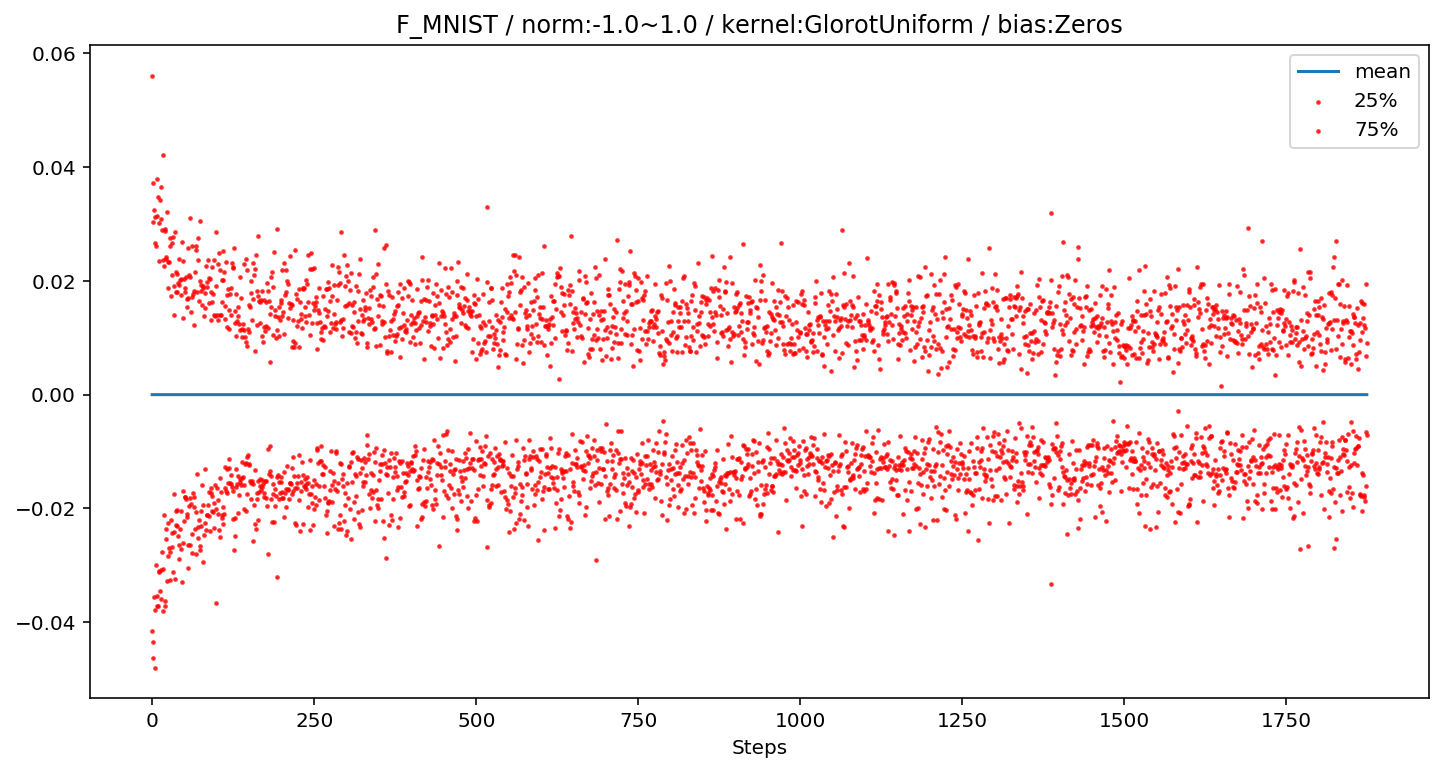

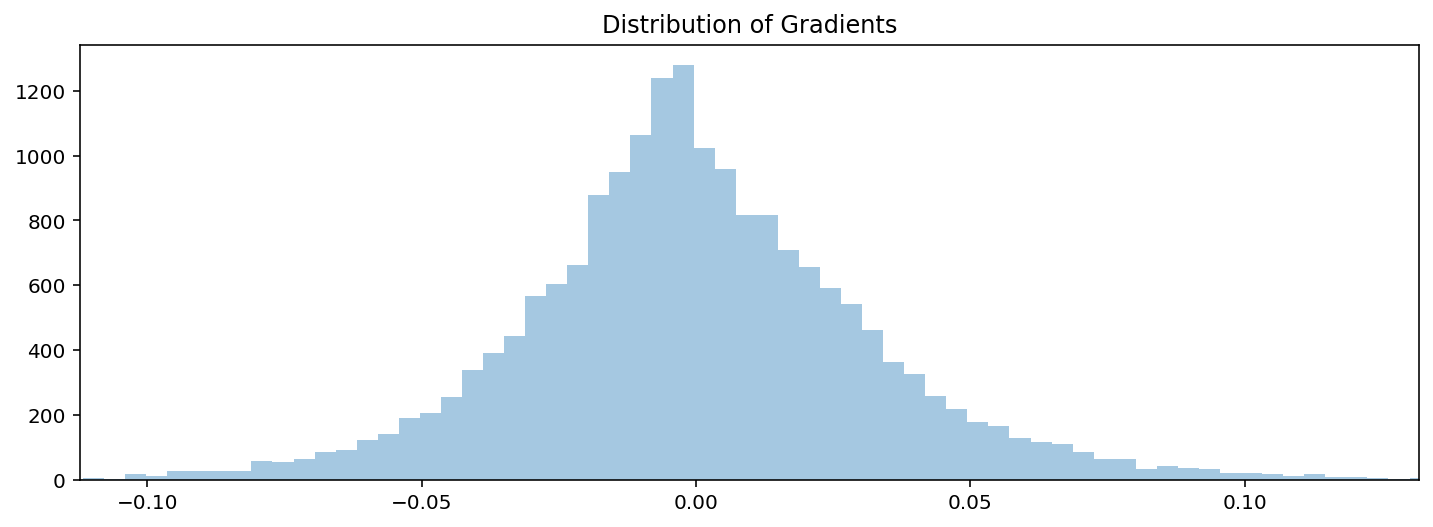

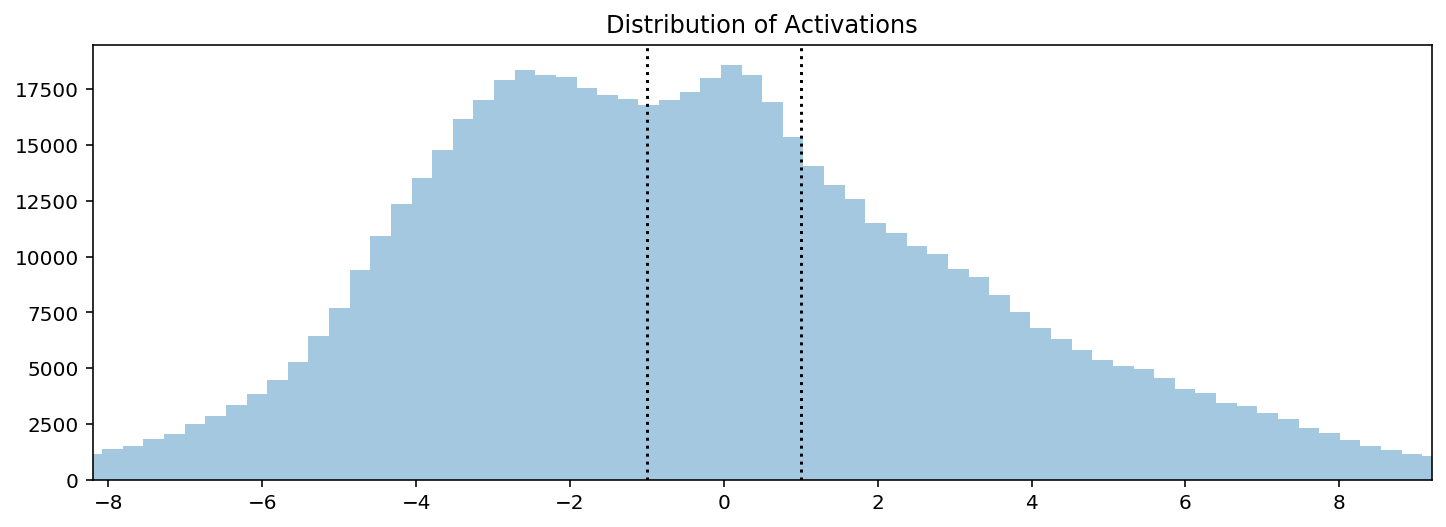

In [0]:
#@title Options { run: "auto" }

#@markdown Data Normalization Scheme
norm_scheme = "-1.0~1.0" #@param ["0.0~1.0", "-1.0~1.0", "none"]

#@markdown Model Initialization Scheme ([see here](https://www.tensorflow.org/api_docs/python/tf/keras/initializers))
k_init = "GlorotUniform" #@param ["GlorotNormal", "GlorotUniform", "Ones", "Zeros", "RandomNormal", "RandomUniform"]
b_init = "Zeros" #@param ["GlorotNormal", "GlorotUniform", "Ones", "Zeros", "RandomNormal", "RandomUniform"]

train_ds, train_steps = load_data(batch_size=32)
gradient_list, loss_list, model, model_int = build_train_model(train_ds, train_steps, epochs=1)
plot_gradients(gradient_list, loss_list)

activations = []
for images, labels in train_ds:
    output = model_int(images).numpy().flatten().tolist()
    activations += output
activations = np.asarray(activations)
a_low, a_high = np.percentile(activations,1), np.percentile(activations,99)

fig = plt.figure(figsize=(12,4))
sns.distplot(activations, bins=100, kde=False)
plt.title("Distribution of Activations")
plt.axvline(-1.0, c="k", linestyle="dotted")
plt.axvline(1.0, c="k", linestyle="dotted")
plt.xlim((a_low, a_high))
plt.show()